In [10]:
# Core data manipulation and analysis libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations and arrays

# Visualization libraries
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations
import seaborn as sns  # For statistical data visualization

# Machine learning libraries
from sklearn import metrics  # For model evaluation metrics
from sklearn.model_selection import train_test_split  # For splitting datasets

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Enable inline plotting in Jupyter notebooks
# Fixed duplicate import and invalid syntax
%matplotlib inline

In [11]:
    
# Reading datasets
# Using list comprehension to read all csv files in 4 csv files
dataframes = [pd.read_csv(f'UNSW-NB15_{i}.csv', header=None) 
       for i in range(1,5)]
    
# Concat all to a single df name combined_data
# Resetting index is important because:
# 1. When concatenating dataframes, the original index values are preserved which can lead to duplicate indices
# 2. Duplicate indices can cause issues with data access, filtering and analysis
# 3. reset_index() creates a clean, sequential index starting from 0
combined_data = pd.concat(dataframes).reset_index(drop=True) 

In [12]:
# Converts null labels to normal.
feature_names = pd.read_csv('features2.csv' )
feature_names_list = feature_names['Name'].tolist()
combined_data.columns = feature_names_list
combined_data.loc[combined_data['attack_cat'].isnull(), 'attack_cat'] = 'Normal'

In [16]:
# Create dataframe of just sport and attack cat columns for function.
df1 = combined_data

In [17]:
# Label correction.
print(df1['attack_cat'].value_counts())

attack_cat
Normal              2218764
Generic              215481
Exploits              44525
 Fuzzers              19195
DoS                   16353
 Reconnaissance       12228
 Fuzzers               5051
Analysis               2677
Backdoor               1795
Reconnaissance         1759
 Shellcode             1288
Backdoors               534
Shellcode               223
Worms                   174
Name: count, dtype: int64


In [18]:
df1['attack_cat'] = df1['attack_cat'].str.strip()

In [19]:
print(df1['attack_cat'].value_counts())

attack_cat
Normal            2218764
Generic            215481
Exploits            44525
Fuzzers             24246
DoS                 16353
Reconnaissance      13987
Analysis             2677
Backdoor             1795
Shellcode            1511
Backdoors             534
Worms                 174
Name: count, dtype: int64


In [20]:
print(df1['sport'].value_counts())


sport
1043     216289
47439    198580
0         50432
47439      4689
1043       4033
          ...  
33785         1
2637          1
29900         1
3664          1
706           1
Name: count, Length: 100341, dtype: int64


In [21]:
# Get a smaller dataframe to make function.
df1 = df1.head(1000000)

In [22]:
# Check number of unique categories in sport (reduced data).
sports = df1['sport'].unique()
print(len(sports))

100287


In [23]:
print(df1['sport'].value_counts())

sport
0        8910
47439    4689
1043     4033
0        3612
47439    2250
         ... 
49266       1
39428       1
3044        1
62086       1
27909       1
Name: count, Length: 100287, dtype: int64


In [29]:
class CorrEncoder:
    """
    CorrEncoder: Takes a dataset as input and uses it for the encode function. Encodes the filtered categories then draws correlations.
    If correlation is above the threshold adds it to a new dataframe then returns the one hot encoded values with the labels.

    Initialisation:
        - data (pd.DataFrame): The Dataset that contains the target column and target label variables.

    """
    def __init__(self, data):
        self.data = data

    def encode(self, target_column, target_label, sparse_n, threshold):
        """
        encode: Takes a target column and target label to encode and draw correlations from. The target column is iterated through
        for all categories that contain more positive values than defined in sparse_n. This allows for filtering of sparse categories.
        The function then one hot encodes the given category with the static target column and draws correlations for them. If correlation
        is greater then threshold then add it to the new DataFrame. The function returns the one hot encoded categories that pass the
        threshold with the target label.

        The purpose of this function is to resolve the high cardinality problem in one hot encoding.

        Parameters:
            - target_column (string): The name of the target column. The target column should contain the various categories to encode.
            - target_label (string): The static label category to encode and draw correlations from.
            - sparse_n (integer): The minimum amount of positive values required for a category after encoding (deals with sparse categories).
            - threshold (float): The threshold for correlation. The function creates onehot encoded columns of all variables that high correlation
              higher that the threshold to the target label.

        Returns:
            - ohe_df (pd.DataFrame): The one hot encoded values from the target column and the encoded target label.

        """
        # Conver to string to handle duplicates.
        self.data[target_column] = self.data[target_column].astype(str)
        value_counts = self.data[target_column].value_counts()
        # Check if number of 1s is above the given threshold set by sparse_n.
        categories = value_counts[value_counts > sparse_n].index.tolist()

        # Create an empty DataFrame to store correlations and encoded data.
        corr_df = pd.DataFrame(index=df1.index)
        ohe_df = pd.DataFrame(index=df1.index)
        corr_list = []
        # Go through each unique category in the target column
        for c in categories:
        # Create column name same as encoding conventions
            col_name = f'{target_column}_{c}'
                
            # Create the binary encoding column for the current category and target label.
            corr_df[col_name] = (self.data[target_column] == c).astype(int)
            attack_cat = (self.data['attack_cat'] == target_label).astype(int)
            correlation = corr_df[col_name].corr(attack_cat)
            # Check if absolute correlation is above the threshold.
            if abs(correlation) > threshold:
                corr_list.append({
                    'Sport': c,
                    'Correlation': correlation
                })
                ohe_df[col_name] = corr_df[col_name]
        # Ommits the error when no values are above thresholds.
        # Creates the dataframe of encoded values with the target label and returns.
        if corr_list:
            corr_table = pd.DataFrame(corr_list)
            corr_table['Correlation'] = corr_table['Correlation'].abs()
            corr_table.sort_values(by='Correlation', ascending=False, inplace=True)
            print("\nCorrelations:")
            print(corr_table)
            print("\nCorrelations Tail:")
            print(corr_table.tail())
        else:
            print("No correlations exceed the threshold.")
        attack_cat = (self.data['attack_cat'] == target_label).astype(int)
        ohe_df['label'] = attack_cat

        return ohe_df

In [30]:
ce = CorrEncoder(df1)
onehot_encoded_values = ce.encode('dsport', 'Fuzzers', 30, 0.01)


Correlations:
   Sport  Correlation
10   179     0.370799
12   445     0.342146
13   514     0.214191
11   520     0.209346
14  1723     0.161763
15   135     0.157866
9      0     0.117918
16    69     0.059653
0     53     0.035027
2   5190     0.017992
3   6881     0.017711
4     25     0.015011
5    111     0.014851
1     80     0.014694
6     22     0.011469
7    143     0.011354
8     21     0.011345

Correlations Tail:
  Sport  Correlation
5   111     0.014851
1    80     0.014694
6    22     0.011469
7   143     0.011354
8    21     0.011345


Index(['dsport_53', 'dsport_80', 'dsport_5190', 'dsport_6881', 'dsport_25',
       'dsport_111', 'dsport_22', 'dsport_143', 'dsport_21', 'dsport_0',
       'dsport_179', 'dsport_520', 'dsport_445', 'dsport_514', 'dsport_1723',
       'dsport_135', 'dsport_69', 'label'],
      dtype='object')
18
1000000


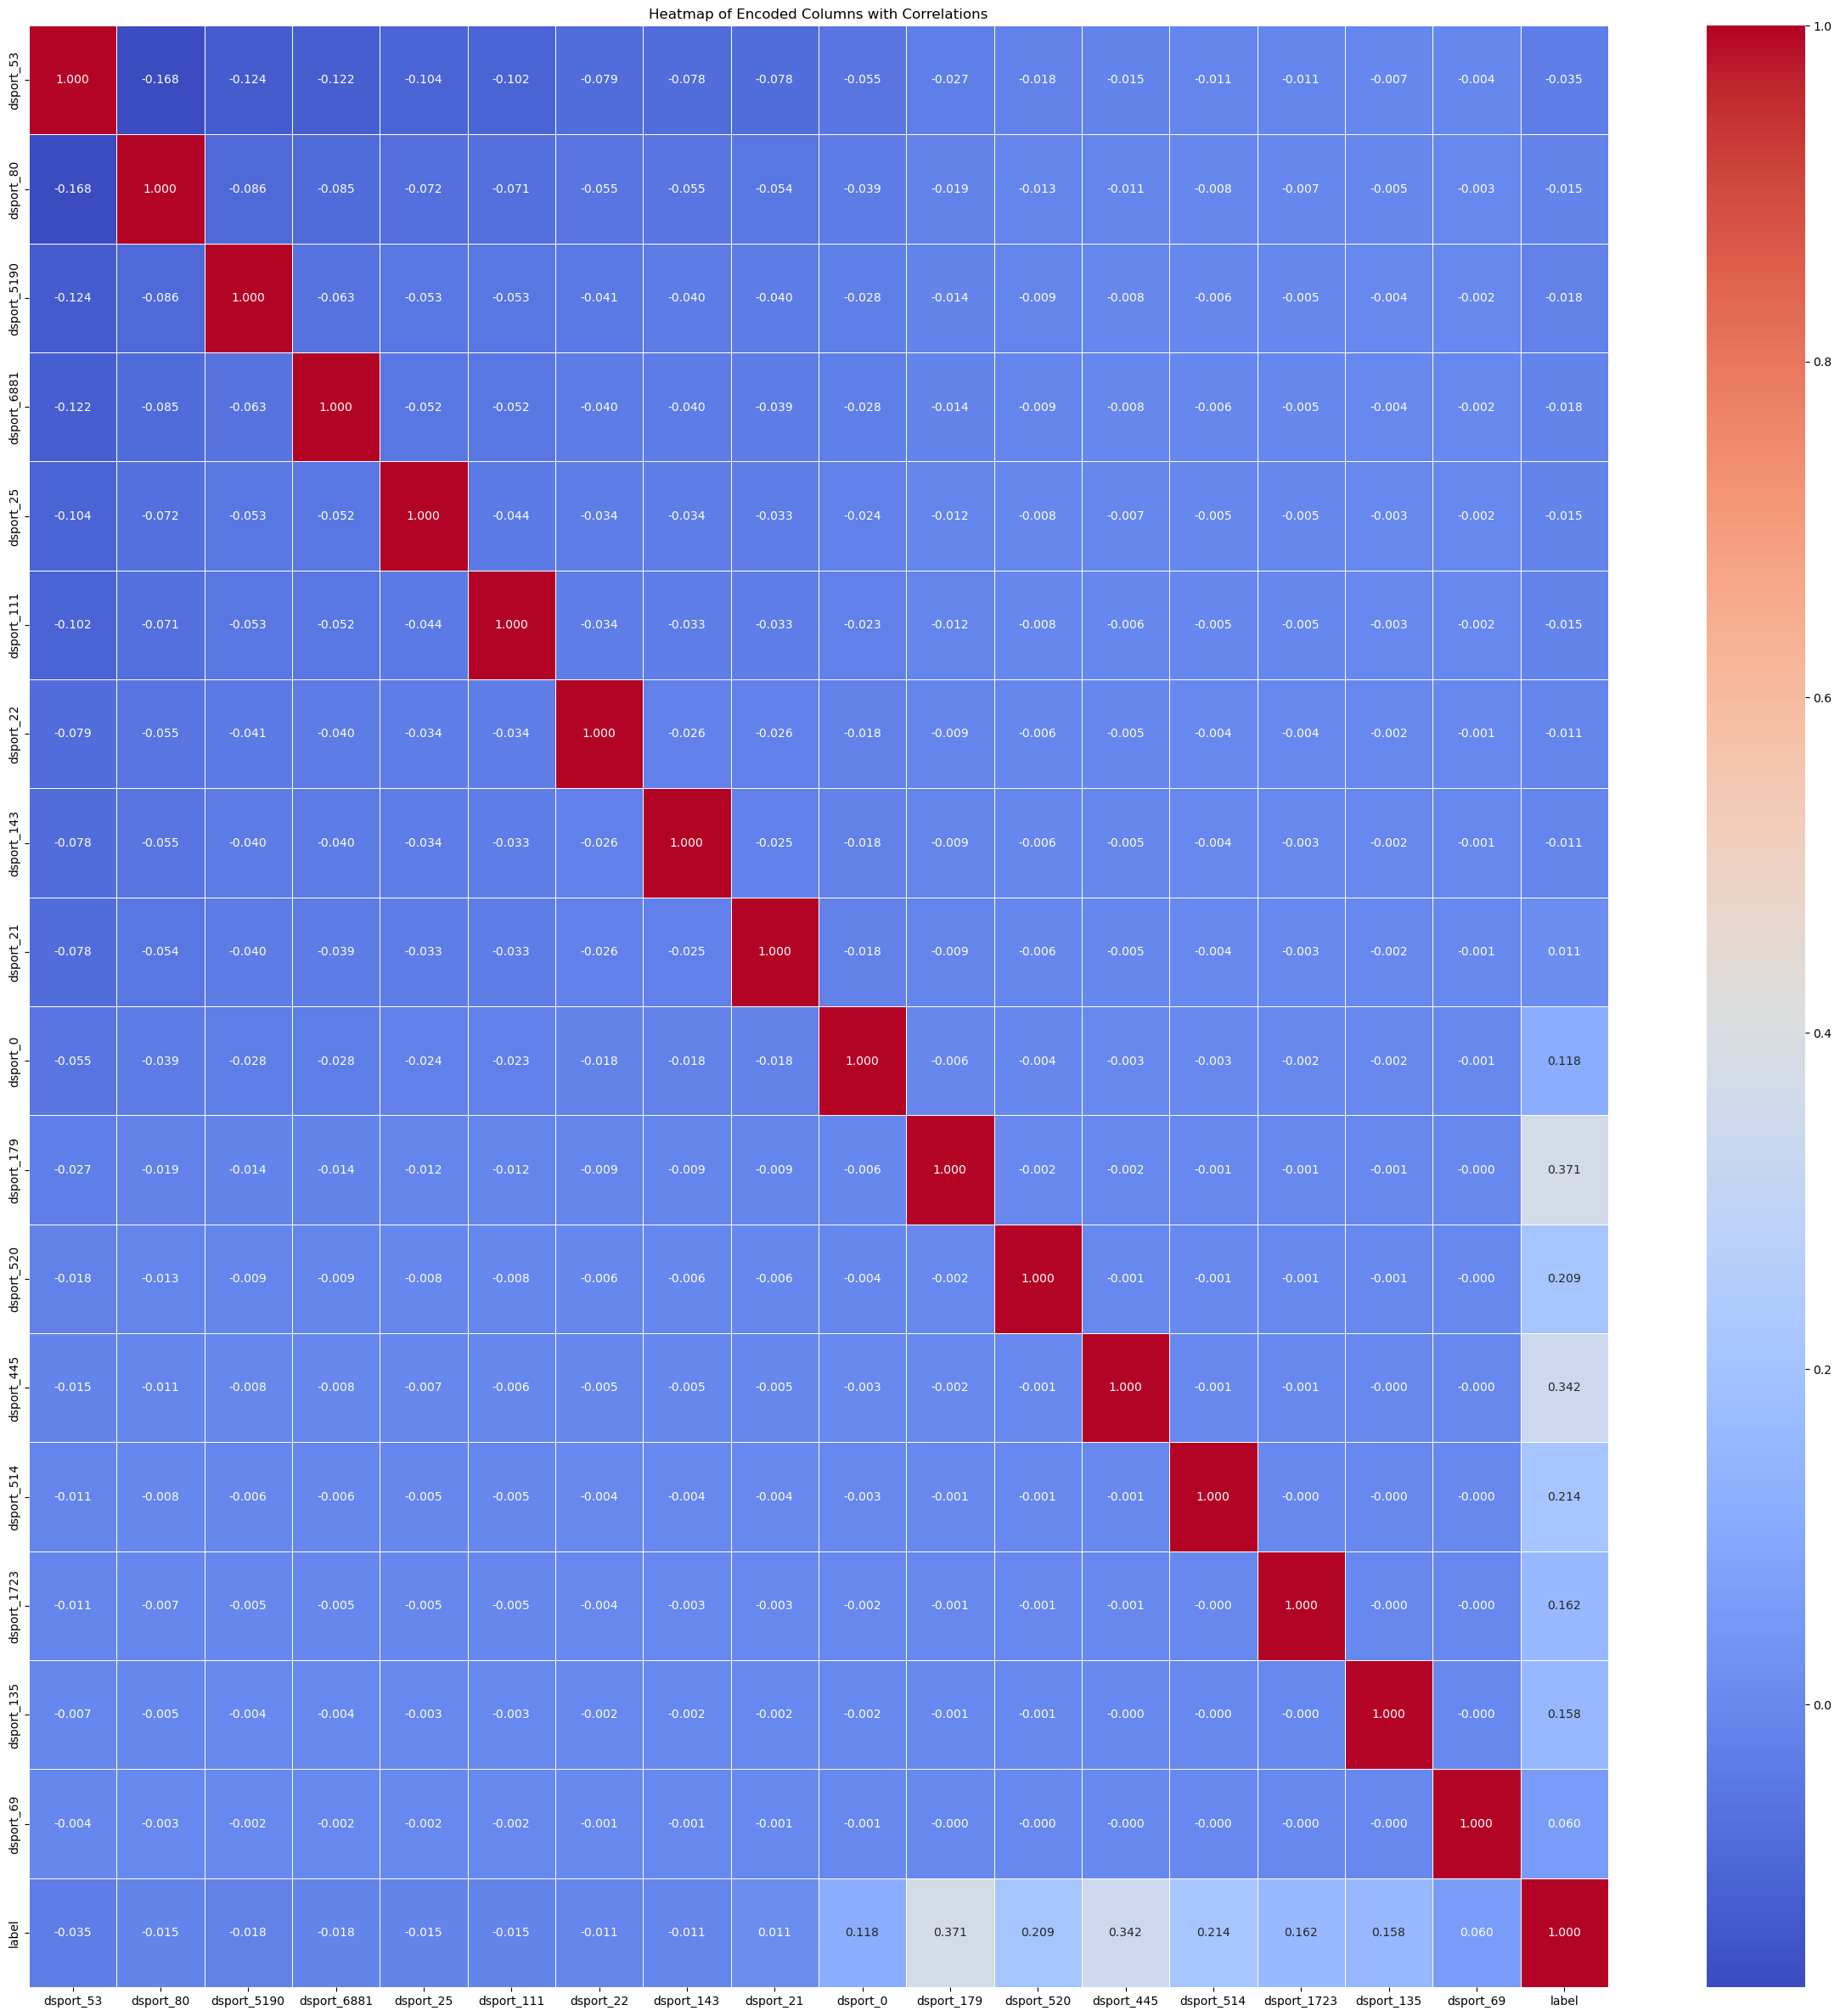

In [31]:
print(onehot_encoded_values.columns)
print(len(onehot_encoded_values.columns))
print(len(onehot_encoded_values))
plt.figure(figsize=(30, 30))
sns.heatmap(onehot_encoded_values.corr(), annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.5)
plt.title("Heatmap of Encoded Columns with Correlations")
plt.show()